# SNIP: Single-shot Network Pruning based on Connection Sensitivity, 19`ICLR
#### code mainly dependent on https://github.com/mil-ad/snip

#### MNIST dataset, LeNet_300_100 model (260 K)

In [1]:
import os
import copy
import types
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision import transforms

#from tensorboardX import SummaryWriter
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss
from ignite.contrib.handlers import ProgressBar

from snip import SNIP
from train import mnist_experiment, apply_prune_mask

from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline

torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

training configuration

In [2]:
LOG_INTERVAL = 20
INIT_LR = 0.1
WEIGHT_DECAY_RATE = 0.0005
EPOCHS = 250
REPEAT_WITH_DIFFERENT_SEED = 1

BATCH_SIZE = 100
LR_DECAY_INTERVAL = 25000

## SNIP algorithm

1. 1개의 minibatch 샘플링
2. 모델 파라미터 (weight) variance scaling initialization
3. loss의 c에 대한 gradient를 구해서 connection sensitivity 계산
4. connection sensitivity sorting 후 pruning (top-k)
5. 프루닝된 모델 학습

## Start pruning

In [3]:
net, optimiser, lr_scheduler, train_loader, val_loader = mnist_experiment(device)

# Pre-training pruning using SNIP
t = time.time()
keep_masks = SNIP(net, 0.05, train_loader, device)  # 95% pruning
apply_prune_mask(net, keep_masks)
print('Pruning is done in {:.2f} sec.'.format(time.time()-t))

tensor(13310, device='cuda:0')
Pruning is done in 2.09 sec.


In [4]:
conv1_mask = keep_masks[0].t()
print(conv1_mask.size())

torch.Size([784, 300])


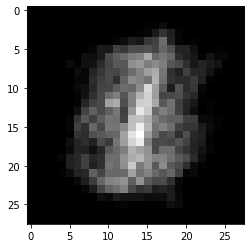

In [5]:
conv1 = conv1_mask.mean(1).reshape(28, 28).cpu().numpy()
imshow(np.asarray(conv1), cmap='gray')

tensor(13310, device='cuda:0')
Pruning is done in 8.04 sec.


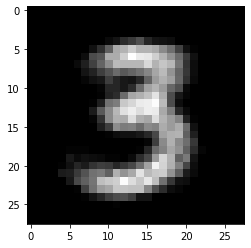

In [6]:
# Pre-training pruning using SKIP
t = time.time()
keep_masks = SNIP(net, 0.05, train_loader, device, label=3)  # only 3's
apply_prune_mask(net, keep_masks)
print('Pruning is done in {:.2f} sec.'.format(time.time()-t))

conv1_mask = keep_masks[0].t()
conv1 = conv1_mask.mean(1).reshape(28, 28).cpu().numpy()
imshow(np.asarray(conv1), cmap='gray')

## Start training

In [ ]:
#writer = SummaryWriter()
trainer = create_supervised_trainer(net, optimiser, F.nll_loss, device)
evaluator = create_supervised_evaluator(net, {
    'accuracy': Accuracy(),
    'nll': Loss(F.nll_loss)
}, device)

pbar = ProgressBar()
pbar.attach(trainer)

@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    lr_scheduler.step()
    iter_in_epoch = (engine.state.iteration - 1) % len(train_loader) + 1
#     if engine.state.iteration % LOG_INTERVAL == 0:
#         # pbar.log_message("Epoch[{}] Iteration[{}/{}] Loss: {:.2f}"
#         #       "".format(engine.state.epoch, iter_in_epoch, len(train_loader), engine.state.output))
#         writer.add_scalar("training/loss", engine.state.output,
#                           engine.state.iteration)

@trainer.on(Events.EPOCH_COMPLETED)
def log_epoch(engine):
    evaluator.run(val_loader)

    metrics = evaluator.state.metrics
    avg_accuracy = metrics['accuracy']
    avg_nll = metrics['nll']

    # pbar.log_message("Validation Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
    #       .format(engine.state.epoch, avg_accuracy, avg_nll))

#     writer.add_scalar("validation/loss", avg_nll, engine.state.iteration)
#     writer.add_scalar("validation/accuracy", avg_accuracy,
#                       engine.state.iteration)

trainer.run(train_loader, EPOCHS)